In [9]:
import argparse
import os

import numpy as np
import torch
from numpy import linalg
from tensorboardX import SummaryWriter
from torch.optim.adamw import AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler
from tqdm import tqdm
from transformers import BertConfig, BertModel, BertTokenizer

from get_dataset import get_dd_corpus, get_zhao_dataset
from utils import (
    dump_config,
    get_correlation,
    draw_scatter_plot,
    load_model,
    save_model,
    softmax_2d,
    set_random_seed,
    get_usencoder,
    write_summary,
)

In [3]:
from eval_bi_encoder import make_annotated_dataset

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
special_tokens_dict = {"additional_special_tokens": ["[SEPT]"]}
tokenizer.add_special_tokens(special_tokens_dict)
raw_dd_train = get_dd_corpus("train")
test_data = make_annotated_dataset(get_zhao_dataset("dd"), tokenizer)
all_uttrs = [uttr for conv in raw_dd_train for uttr in conv]

{'corpus': 'dd',
 'ctx': ['sure . where do you want to go ? are you in the mood for anything in '
         'particular ?',
         "how about some dumplings ? i just ca n't get enough of them .",
         "dumplings again ? ! oh , amy , let 's try something new !",
         'well , what do you have in mind ?',
         'how about the mongolian hot pot ?'],
 'human_score': 1.75,
 'hyp': 'did you go to school today ?',
 'model': 'negative-sample',
 'ref': "oh , it 's too spicy for me . do n't you remember last time when i "
        'tasted the lamb ? it was so spicy my eyes teared up !'}


In [6]:
with open("./data/cache/dd-response-bi64-epoch0-1000.json",'rb') as f:
    response_score = np.load(f)
with open("./data/cache/dd-hyp-bi64-epoch0-1000.json",'rb') as f:
    hyp_score = np.load(f)

In [12]:
!pip install tensorflow_hub
use_model = get_usencoder()

     |████████████████████████████████| 108 kB 1.6 MB/s eta 0:00:01


INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 160.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 310.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 470.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 630.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 790.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 910.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [45]:
from nlgeval import NLGEval
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from bert_score import score as bertscore
from nltk.translate.bleu_score import sentence_bleu
from matplotlib import pyplot as plt
import pickle

In [68]:
nlgeval = NLGEval(metrics_to_omit=["SkipThoughtCS"])

def get_similarity_score(metric:str, ref, hyp:str):
    assert isinstance(ref,list) and isinstance(hyp,str)
    if metric == 'use':
        ref_emb_list = use_model(ref)
        hyp_emb_list = use_model([hyp])
        sim_list = cosine_similarity(hyp_emb_list, ref_emb_list)[0]
        assert len(sim_list) == len(ref)
        return [float(el) for el in sim_list]
    elif metric == 'bertscore':
        return [float(el) for el in bertscore([hyp for _ in range(len(ref))], ref, rescale_with_baseline=True, lang="en")[-1]]
    elif metric == 'bleu1':
        sim = [sentence_bleu([el.split()],hyp.split(),(1,0,0,0)) for el in ref]
        return sim
    elif metric == 'bleu2':
        sim = [sentence_bleu([el.split()],hyp.split(),(0,1,0,0)) for el in ref]
        return sim
    elif metric == 'bleu1/2':
        sim = [sentence_bleu([el.split()],hyp.split(),(0.5,0.5,0,0)) for el in ref]
        return sim
    elif metric =='embeddingAvg':
        result = [nlgeval.compute_individual_metrics([el],hyp) for el in ref]
        sim_avg = [el['EmbeddingAverageCosineSimilarity'] for el in result]
        return sim_avg
    elif metric =='embeddingGrd':
        result = [nlgeval.compute_individual_metrics([el],hyp) for el in ref]
        sim_grd = [el['GreedyMatchingScore'] for el in result]
        return sim_grd
    elif metric =='embeddingExt':
        result = [nlgeval.compute_individual_metrics([el],hyp) for el in ref]
        sim_ext = [el['VectorExtremaCosineSimilarity'] for el in result]
        return sim_ext
        

total_result = {}
        
for metric in ['embeddingAvg','embeddingGrd','embeddingExt','use','bleu1','bleu2','bleu1/2']:
    total_result[metric] = {}
    print(metric)
    for retrieve_num in [10,50,100,200,500]:
        print(retrieve_num)
        total_result[metric][retrieve_num] = {}
        sorted_response_index = np.argsort(-response_score,1)[:,:retrieve_num]
        sorted_response_uttrs = [[all_uttrs[idx] for idx in one_indices] for one_indices in sorted_response_index]

        # ctx, ref, hyp, score = item
        mean_pred, max_pred,median_pred , min_pred= [[],[],[],[]]
        humanscore = []
        ref_pred = []
        for idx,item in enumerate(tqdm(test_data)):
            ctx, ref, hyp, score = item
            
            # prepare input
            humanscore.append(score)
            hyp = ' '.join(tokenizer.convert_ids_to_tokens(hyp[1:-1])).replace(" ##",'')
            ref = ' '.join(tokenizer.convert_ids_to_tokens(ref[1:-1])).replace(" ##",'')
            retrieved_candidate = sorted_response_uttrs[idx]
            
            # get similarity
            hyp_ref_score = get_similarity_score(metric,[ref],hyp)
            candidate_score = get_similarity_score(metric,retrieved_candidate,hyp)
            assert len(hyp_ref_score) == 1 
            assert len(candidate_score) == retrieve_num 
            
            ref_pred.append(hyp_ref_score[0])
            mean_pred.append(np.mean(candidate_score))
            median_pred.append(np.median(candidate_score))
            min_pred.append(np.min(candidate_score))
            max_pred.append(np.max(candidate_score))

        ref_score = get_correlation(humanscore, ref_pred)
        mean_score = get_correlation(humanscore, mean_pred)
        median_score = get_correlation(humanscore, median_pred)
        max_score = get_correlation(humanscore, max_pred)
        min_score = get_correlation(humanscore, min_pred)
        
        total_result[metric][retrieve_num]['ref'] = ref_score
        total_result[metric][retrieve_num]['mean'] = mean_score
        total_result[metric][retrieve_num]['median'] = median_score
        total_result[metric][retrieve_num]['max'] = max_score
        total_result[metric][retrieve_num]['min'] = min_score
        

with open("result.pck",'wb') as f:
    pickle.dump(total_result, f)

embeddingAvg
10


100%|██████████| 800/800 [00:27<00:00, 29.42it/s]


50


  4%|▍         | 34/800 [00:04<01:40,  7.61it/s]


KeyboardInterrupt: 

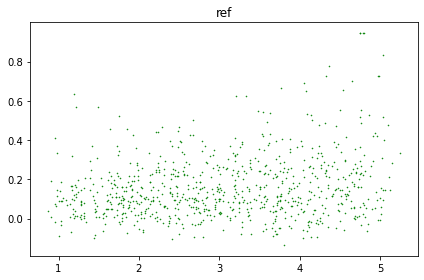

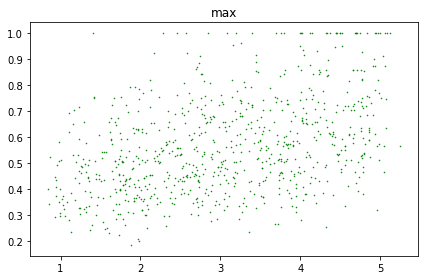

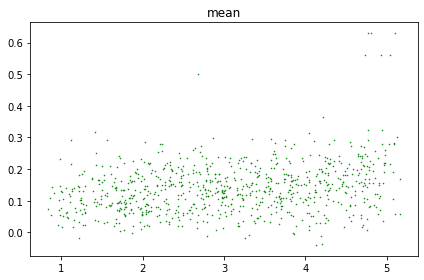

In [42]:
def draw_scatter_plot(title, x, y):
    x = [el + np.random.normal(0, 0.3 * 0.3, 1)[0] for el in x]
    fig, axs = plt.subplots()
    axs.set_title(title)
    axs.set_title(title)
    axs.set_xticks([1, 2, 3, 4, 5])
    axs.scatter(x, y, s=0.3, c="green")

    plt.tight_layout()
    plt.show()
    


draw_scatter_plot('ref',humanscore, ref_pred)
draw_scatter_plot('max',humanscore, max_pred)
draw_scatter_plot('mean',humanscore, mean_pred)